The following model is a two steps classification process.
The first step consist of predicting if there will be a departure delay or a cancelation.
The second step consist of predicting if there will be an arrival delay once the flight occurs.
The goal of this two steps classification process is to leverage the information from the real time of departure in order to improve the classification of arrival delays.

The results are far from good for the first step of the classification without using the weather data. Using this information would surely improve the model. However, we can see that the results of the second step are already satisfying without even using the weather data.

# **Import Flight Data**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
import random
random.seed(348)

flight_data   = pd.read_csv('departures_v2.csv', sep='\t')
#flight_data   = pd.read_csv('departures.csv', sep='\t')
#flight_data   = pd.read_csv('departures.txt', sep='\t')


In [2]:
!pip install seaborn

In [3]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281604 entries, 0 to 281603
Data columns (total 24 columns):
mode                              281604 non-null object
flight_number                     281604 non-null object
callsign                          269291 non-null object
aircraft_model_code               281459 non-null object
aircraft_model_description        272507 non-null object
aircraft_registration             272652 non-null object
airline_name                      281604 non-null object
airline_iata                      281604 non-null object
airline_icao                      281604 non-null object
flight_origin_code_iata           281604 non-null object
flight_origin_code_icao           281507 non-null object
flight_origin_name                281604 non-null object
flight_origin_time_offset         281604 non-null int64
flight_destination_code_iata      281604 non-null object
flight_destination_code_icao      281493 non-null object
flight_destination_name           2

In [4]:
flight_data.head()

,mode,flight_number,callsign,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,airline_iata,airline_icao,flight_origin_code_iata,...,flight_destination_code_icao,flight_destination_name,flight_destination_time_offset,flight_departure_scheduled,flight_departure_real,flight_arrival_scheduled,flight_arrival_real,flight_duration,departure_status,arrival_status
0,arrivals,JL41,JAL41,B788,Boeing 787-8 Dreamliner,JA837J,Japan Airlines,JL,JAL,HND,...,EGLL,London Heathrow Airport,3600,1558284900,1558287066,1558329900,1558329002,41940.0,delayed,early arrival
1,arrivals,SA234,SAA234,A333,Airbus A330-343,ZS-SXK,South African Airways,SA,SAA,JNB,...,EGLL,London Heathrow Airport,3600,1558288800,1558289714,1558329900,1558329449,39720.0,ontime,early arrival
2,arrivals,QF1,QFA1,A388,Airbus A380-842,VH-OQA,Qantas,QF,QFA,SIN,...,EGLL,London Heathrow Airport,3600,1558281300,1558285951,1558329900,1558332793,46860.0,long delayed,delayed
3,arrivals,BI3,RBA003,B788,Boeing 787-8 Dreamliner,V8-DLD,Royal Brunei Airlines,BI,RBA,BWN,...,EGLL,London Heathrow Airport,3600,1558277700,1558278026,1558329900,1558329158,51120.0,ontime,early arrival
4,arrivals,VS4,VIR4C,A333,Airbus A330-343,G-VWAG,Virgin Atlantic,VS,VIR,JFK,...,EGLL,London Heathrow Airport,3600,1558303200,1558306094,1558329900,1558329337,23220.0,delayed,early arrival


In [5]:
flight_data['departure_status'].unique()

array(['delayed', 'ontime', 'long delayed', 'very long delayed',
       'early departure', 'Flight Cancelled'], dtype=object)

In [6]:
flight_data[flight_data['departure_status'] == 'Flight Cancelled'].head()

,mode,flight_number,callsign,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,airline_iata,airline_icao,flight_origin_code_iata,...,flight_destination_code_icao,flight_destination_name,flight_destination_time_offset,flight_departure_scheduled,flight_departure_real,flight_arrival_scheduled,flight_arrival_real,flight_duration,departure_status,arrival_status
48,arrivals,LH922,NaN,A321,Airbus A321-131,D-AIRE,Lufthansa,LH,DLH,FRA,...,EGLL,London Heathrow Airport,3600,1558294200,-1,1558300200,-1,NaN,Flight Cancelled,Flight Cancelled
77,arrivals,EI184,NaN,A320,Airbus A320-214,EI-DVH,Aer Lingus,EI,EIN,DUB,...,EGLL,London Heathrow Airport,3600,1558293000,-1,1558297800,-1,NaN,Flight Cancelled,Flight Cancelled
103,arrivals,LH2482,NaN,319,NaN,NaN,Lufthansa,LH,DLH,MUC,...,EGLL,London Heathrow Airport,3600,1558287900,-1,1558295100,-1,NaN,Flight Cancelled,Flight Cancelled
192,arrivals,LH918,NaN,A20N,Airbus A320-271N,D-AINR,Lufthansa,LH,DLH,FRA,...,EGLL,London Heathrow Airport,3600,1558281600,-1,1558287600,-1,NaN,Flight Cancelled,Flight Cancelled
307,arrivals,LH910,NaN,A320,Airbus A320-214,D-AIWD,Lufthansa,LH,DLH,FRA,...,EGLL,London Heathrow Airport,3600,1558270800,-1,1558276800,-1,NaN,Flight Cancelled,Flight Cancelled


In [7]:
# Remove some rows, drop a column and modify one column
depOnly_nan = flight_data[ ( flight_data['flight_departure_real'].isnull() ) & (~flight_data['flight_arrival_real'].isnull() ) ].index # Bad data, how can we not have real info for departure but for arrival?
arrOnly_nan = flight_data[ (~flight_data['flight_departure_real'].isnull() ) & ( flight_data['flight_arrival_real'].isnull() ) ].index # Bad data, how can we have real info for departure but not for arrival? Crash or bad data!
flight_data.drop(depOnly_nan, inplace=True)
flight_data.drop(arrOnly_nan, inplace=True)
flight_data.drop(['departure_status','arrival_status'], axis=1, inplace=True)
flight_data['aircraft_registration'] = flight_data['aircraft_registration'].str.extract('([A-Za-z]+)\-') # Only get the first letter in the registration code

In [8]:
flight_data.drop(['flight_duration'], axis=1, inplace=True)

# Remove outliers

In [9]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [10]:
# no_cancelations_df["delay_time"].describe()

In [11]:
no_cancelations_df = flight_data[flight_data['flight_departure_real'] != -1 ]
cancelations_df = flight_data[flight_data['flight_departure_real'] == -1 ]
print( len(no_cancelations_df) + len(cancelations_df))

281604


In [12]:
no_cancelations_df['delay_time'] = no_cancelations_df['flight_departure_real'] - no_cancelations_df['flight_departure_scheduled']

C:\tools\miniconda3\envs\agifors\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
no_cancelations_df.head()

,mode,flight_number,callsign,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,airline_iata,airline_icao,flight_origin_code_iata,...,flight_origin_time_offset,flight_destination_code_iata,flight_destination_code_icao,flight_destination_name,flight_destination_time_offset,flight_departure_scheduled,flight_departure_real,flight_arrival_scheduled,flight_arrival_real,delay_time
0,arrivals,JL41,JAL41,B788,Boeing 787-8 Dreamliner,NaN,Japan Airlines,JL,JAL,HND,...,32400,LHR,EGLL,London Heathrow Airport,3600,1558284900,1558287066,1558329900,1558329002,2166
1,arrivals,SA234,SAA234,A333,Airbus A330-343,ZS,South African Airways,SA,SAA,JNB,...,7200,LHR,EGLL,London Heathrow Airport,3600,1558288800,1558289714,1558329900,1558329449,914
2,arrivals,QF1,QFA1,A388,Airbus A380-842,VH,Qantas,QF,QFA,SIN,...,28800,LHR,EGLL,London Heathrow Airport,3600,1558281300,1558285951,1558329900,1558332793,4651
3,arrivals,BI3,RBA003,B788,Boeing 787-8 Dreamliner,NaN,Royal Brunei Airlines,BI,RBA,BWN,...,28800,LHR,EGLL,London Heathrow Airport,3600,1558277700,1558278026,1558329900,1558329158,326
4,arrivals,VS4,VIR4C,A333,Airbus A330-343,G,Virgin Atlantic,VS,VIR,JFK,...,-14400,LHR,EGLL,London Heathrow Airport,3600,1558303200,1558306094,1558329900,1558329337,2894


In [14]:
no_cancelations_df_without_outliers = remove_outlier(no_cancelations_df, 'delay_time')

In [15]:
df_no_outliers = pd.concat([no_cancelations_df_without_outliers.drop('delay_time', axis=1), cancelations_df])

In [16]:
flight_data = df_no_outliers.sample(frac=1).reset_index(drop=True)
print(len(flight_data), len(no_cancelations_df), len(no_cancelations_df_without_outliers), len(df_no_outliers), len(cancelations_df))

258374 268871 245641 258374 12733


In [17]:
flight_data.head()

,mode,flight_number,callsign,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,airline_iata,airline_icao,flight_origin_code_iata,...,flight_origin_name,flight_origin_time_offset,flight_destination_code_iata,flight_destination_code_icao,flight_destination_name,flight_destination_time_offset,flight_departure_scheduled,flight_departure_real,flight_arrival_scheduled,flight_arrival_real
0,arrivals,AF475,AFR475,B789,Boeing 787-9 Dreamliner,F,Air France,AF,AFR,PTY,...,Panama City Tocumen International Airport,-18000,CDG,LFPG,Paris Charles de Gaulle Airport,7200,1559350800,1559351531,1559388000,1559385938
1,arrivals,LH591,DLH591,A333,Airbus A330-343,D,Lufthansa,LH,DLH,NBO,...,Nairobi Jomo Kenyatta International Airport,10800,FRA,EDDF,Frankfurt Airport,7200,1558293900,1558294870,1558323600,1558322954
2,departures,U2895,EZY36JH,A319,Airbus A319-111,G,easyJet (UNICEF Livery),U2,EZY,LGW,...,London Gatwick Airport,3600,JER,EGJJ,Jersey Airport,3600,1559664900,1559666740,1559668800,1559668924
3,departures,OA354,OAL4SR,A320,Airbus A320-232,SX,Aegean Airlines,A3,AEE,ATH,...,Athens Eleftherios Venizelos,10800,JTR,LGSR,Santorini Thira National Airport,10800,1559805000,1559806472,1559807700,1559808006
4,arrivals,DL722,DAL722,B752,Boeing 757-232,NaN,Delta Air Lines,DL,DAL,AUA,...,Oranjestad Queen Beatrix International Airport,-14400,JFK,KJFK,New York John F. Kennedy International Airport,-14400,1558463100,1558463486,1558479152,1558478840


# Create target **variables**

Identification of a cancelation, departure delay and arrival delay in each flight (Binary features)

In [18]:
flight_data['Cancelations'] =  ( flight_data['flight_departure_real'] == -1 ) * 1
flight_data['Departure_delay'] = ( ( flight_data['flight_departure_real'] - flight_data['flight_departure_scheduled'] ) > 900 ) * 1
flight_data['Arrival_delay'] = ( ( flight_data['flight_arrival_real'] - flight_data['flight_arrival_scheduled'] ) > 900 ) * 1

Create target variables (1 for each of the two training steps and the main target variable)

In [19]:
# This is the target variable we want to predict in the end, good feature for data analysis (group by) even if not use as target variable
def label_class_main(row):
  if   row['Cancelations'] == 0 and row['Departure_delay'] == 0 and row['Arrival_delay'] == 0 :
      return 'No delay No cancelation'
  elif row['Cancelations'] == 0 and row['Departure_delay'] == 0 and row['Arrival_delay'] == 1 :
      return 'Arrival delay'
  elif row['Cancelations'] == 0 and row['Departure_delay'] == 1 and row['Arrival_delay'] == 0 :
      return 'Departure delay'
  elif row['Cancelations'] == 0 and row['Departure_delay'] == 1 and row['Arrival_delay'] == 1 :
      return 'Departure delay Arrival delay'
  elif row['Cancelations'] == 1  :
      return 'Cancelation'

# Target variable for step 1
def label_class_1step(row):
  if   row['Cancelations'] == 0 and row['Departure_delay'] == 0 :
      return 'No delay No cancelation'
  elif row['Cancelations'] == 0 and row['Departure_delay'] == 1 :
      return 'Departure delay'
  elif row['Cancelations'] == 1  :
      return 'Cancelation'

# Target variable for step 2
def label_class_2step(row):
  if   row['Arrival_delay'] == 0 :
      return 'No arrival delay'
  elif row['Arrival_delay'] == 1 :
      return 'Arrival delay'

In [20]:
flight_data['main_target'] = flight_data.apply( lambda row: label_class_main(row), axis=1 )
flight_data['target_1step'] = flight_data.apply( lambda row: label_class_1step(row), axis=1 )
flight_data['target_2step'] = flight_data.apply( lambda row: label_class_2step(row), axis=1 )

In [21]:
flight_data_base = flight_data.copy()

In [22]:
display(flight_data_base['target_1step'].value_counts())

Departure delay            148033
No delay No cancelation     97608
Cancelation                 12733
Name: target_1step, dtype: int64

In [23]:
display(flight_data_base['target_2step'].value_counts())

No arrival delay    229339
Arrival delay        29035
Name: target_2step, dtype: int64

In [24]:
np.sum(flight_data.isnull()*1)

mode                                   0
flight_number                          0
callsign                           12200
aircraft_model_code                  122
aircraft_model_description          8975
aircraft_registration             111101
airline_name                           0
airline_iata                           0
airline_icao                           0
flight_origin_code_iata                0
flight_origin_code_icao               97
flight_origin_name                     0
flight_origin_time_offset              0
flight_destination_code_iata           0
flight_destination_code_icao         111
flight_destination_name                0
flight_destination_time_offset         0
flight_departure_scheduled             0
flight_departure_real                  0
flight_arrival_scheduled               0
flight_arrival_real                    0
Cancelations                           0
Departure_delay                        0
Arrival_delay                          0
main_target     

# **Fill NaN**

In [25]:
# Fill NaN of categorical variables
for column in list(flight_data.select_dtypes('object').columns):
    flight_data[column].fillna('NoData', inplace=True)

# Add new **features**

In [26]:
flight_data['diff_arr_sched_dep_sched'] = flight_data['flight_arrival_scheduled'] - flight_data['flight_departure_scheduled']         # Duration of the scheduled flight
flight_data['diff_dep_real_dep_sched'] = flight_data['flight_departure_real'] - flight_data['flight_departure_scheduled']             # Difference between real departure time and scheduled departure time (delay)
flight_data['diff_arr_sched_dep_real'] = flight_data['flight_arrival_scheduled'] - flight_data['flight_departure_real']               # Difference between arrival scheduled time and real departure time
flight_data['hour_dep_sched'] = flight_data['flight_departure_scheduled'].apply(lambda x: datetime.fromtimestamp(x).hour).values      # Hour of the day of departure scheduled
flight_data['hour_arr_sched'] = flight_data['flight_arrival_scheduled'].apply(lambda x: datetime.fromtimestamp(x).hour).values        # Hour of the day of arrival scheduled

# Columns to merge weather data (dep_sched for step1 and arr_sched for step2)
flight_data['Date_hour_dep_sched'] = flight_data['flight_departure_scheduled'].apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x)).round('H')).values
flight_data['Date_hour_arr_sched'] = flight_data['flight_arrival_scheduled'].apply(lambda x: pd.to_datetime(datetime.fromtimestamp(x)).round('H')).values

In [27]:
np.sum(flight_data.isnull()*1)

mode                              0
flight_number                     0
callsign                          0
aircraft_model_code               0
aircraft_model_description        0
aircraft_registration             0
airline_name                      0
airline_iata                      0
airline_icao                      0
flight_origin_code_iata           0
flight_origin_code_icao           0
flight_origin_name                0
flight_origin_time_offset         0
flight_destination_code_iata      0
flight_destination_code_icao      0
flight_destination_name           0
flight_destination_time_offset    0
flight_departure_scheduled        0
flight_departure_real             0
flight_arrival_scheduled          0
flight_arrival_real               0
Cancelations                      0
Departure_delay                   0
Arrival_delay                     0
main_target                       0
target_1step                      0
target_2step                      0
diff_arr_sched_dep_sched    

In [28]:
flight_data.head()

,mode,flight_number,callsign,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,airline_iata,airline_icao,flight_origin_code_iata,...,main_target,target_1step,target_2step,diff_arr_sched_dep_sched,diff_dep_real_dep_sched,diff_arr_sched_dep_real,hour_dep_sched,hour_arr_sched,Date_hour_dep_sched,Date_hour_arr_sched
0,arrivals,AF475,AFR475,B789,Boeing 787-9 Dreamliner,F,Air France,AF,AFR,PTY,...,No delay No cancelation,No delay No cancelation,No arrival delay,37200,731,36469,21,7,2019-05-31 21:00:00,2019-06-01 07:00:00
1,arrivals,LH591,DLH591,A333,Airbus A330-343,D,Lufthansa,LH,DLH,NBO,...,Departure delay,Departure delay,No arrival delay,29700,970,28730,15,23,2019-05-19 15:00:00,2019-05-20 00:00:00
2,departures,U2895,EZY36JH,A319,Airbus A319-111,G,easyJet (UNICEF Livery),U2,EZY,LGW,...,Departure delay,Departure delay,No arrival delay,3900,1840,2060,12,13,2019-06-04 12:00:00,2019-06-04 13:00:00
3,departures,OA354,OAL4SR,A320,Airbus A320-232,SX,Aegean Airlines,A3,AEE,ATH,...,Departure delay,Departure delay,No arrival delay,2700,1472,1228,3,3,2019-06-06 03:00:00,2019-06-06 04:00:00
4,arrivals,DL722,DAL722,B752,Boeing 757-232,NoData,Delta Air Lines,DL,DAL,AUA,...,No delay No cancelation,No delay No cancelation,No arrival delay,16052,386,15666,14,18,2019-05-21 14:00:00,2019-05-21 19:00:00


# Fill NaN of new **features**

In [29]:
# Replace NaN with high number
flight_data['diff_dep_real_dep_sched'].fillna(9999999, inplace=True)
flight_data['diff_arr_sched_dep_real'].fillna(9999999, inplace=True)

In [30]:
def get_hour(x):
    if x>0:
        return datetime.fromtimestamp(x).hour

In [31]:
flight_data['flight_departure_real'].fillna(0, inplace=True) # Not sure of the impact of filling these NaN to 0 instead of something else
flight_data['flight_arrival_real'].fillna(0, inplace=True) 
flight_data['hour_dep_real'] = flight_data['flight_departure_real'].apply(get_hour) # New feature! Hour of the day of departure real. But needed to fill NaN to construct it

In [32]:
np.sum(flight_data.isnull()*1)

mode                                  0
flight_number                         0
callsign                              0
aircraft_model_code                   0
aircraft_model_description            0
aircraft_registration                 0
airline_name                          0
airline_iata                          0
airline_icao                          0
flight_origin_code_iata               0
flight_origin_code_icao               0
flight_origin_name                    0
flight_origin_time_offset             0
flight_destination_code_iata          0
flight_destination_code_icao          0
flight_destination_name               0
flight_destination_time_offset        0
flight_departure_scheduled            0
flight_departure_real                 0
flight_arrival_scheduled              0
flight_arrival_real                   0
Cancelations                          0
Departure_delay                       0
Arrival_delay                         0
main_target                           0


In [33]:
flight_data['aircraft_model_code'].value_counts()

A320    43405
B738    40319
A321    21699
A319    21125
E75L     9378
        ...  
77L         1
SR20        1
753         1
100         1
TBM9        1
Name: aircraft_model_code, Length: 295, dtype: int64

# Feature **engineering**

In [34]:
# Change least frequent categories to 'Others'
# All categories with value counts < 100 are changed to others (This is totally arbitrary, can and should be changed either on a per case basis on percentage basis)
threshold = 300

models_counts = flight_data['aircraft_model_code'].value_counts()
flight_data['aircraft_model_code'] = flight_data['aircraft_model_code'].replace(list(models_counts[models_counts < threshold].index), 'Others')

models_counts = flight_data['aircraft_model_description'].value_counts()
flight_data['aircraft_model_description'] = flight_data['aircraft_model_description'].replace(list(models_counts[models_counts < threshold].index), 'Others')

models_counts = flight_data['aircraft_registration'].value_counts()
flight_data['aircraft_registration'] = flight_data['aircraft_registration'].replace(list(models_counts[models_counts < threshold].index), 'Others')

models_counts = flight_data['airline_name'].value_counts()
flight_data['airline_name'] = flight_data['airline_name'].replace(list(models_counts[models_counts < threshold].index), 'Others')

models_counts = flight_data['flight_origin_code_icao'].value_counts()
flight_data['flight_origin_code_icao'] = flight_data['flight_origin_code_icao'].replace(list(models_counts[models_counts < threshold].index), 'Others')

models_counts = flight_data['flight_destination_code_icao'].value_counts()
flight_data['flight_destination_code_icao'] = flight_data['flight_destination_code_icao'].replace(list(models_counts[models_counts < threshold].index), 'Others')

In [35]:
#models_counts #/ models_counts.sum()

# **Import and clean weather data**

Did not get the time to approprietly join the weather data with the flights data

In [36]:
metar_df = pd.read_csv('METAR_all_airports.csv')
#metar_df = pd.read_csv('Metar.txt')
metar_df.head()

,AIRPORT_IATA,AIRPORT_ICAO,UTC DATE/TIME,METAR,DESCRIPTION
0,LHR,EGLL,2019-05-18 23:50:00,EGLL 182350Z AUTO 01003KT 9999 NCD 11/09 Q1009...,Day: 18th Time: 23:50 UTC Wind direction: 10 W...
1,LHR,EGLL,2019-05-18 23:20:00,EGLL 182320Z AUTO 02002KT 9999 NCD 10/08 Q1009...,Day: 18th Time: 23:20 UTC Wind direction: 20 W...
2,LHR,EGLL,2019-05-18 22:50:00,EGLL 182250Z AUTO 04002KT 9999 NCD 12/09 Q1009...,Day: 18th Time: 22:50 UTC Wind direction: 40 W...
3,LHR,EGLL,2019-05-18 22:20:00,EGLL 182220Z AUTO 06002KT 9999 NCD 12/09 Q1008,Day: 18th Time: 22:20 UTC Wind direction: 60 W...
4,LHR,EGLL,2019-05-18 21:50:00,EGLL 182150Z AUTO VRB02KT 9999 NCD 13/09 Q1008...,Day: 18th Time: 21:50 UTC Wind speed: 2kt Temp...


In [37]:
metar_df['DESCRIPTION'].iloc[555]

'Day: 18th Time: 16:51 UTC Wind direction: 330 Wind speed: 7kt Wind gust: 15kt Temperature: 23C Dew point: 2C Pressure: 29.99 inHg Visibility: 10 SM'

In [38]:
metar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13477 entries, 0 to 13476
Data columns (total 5 columns):
AIRPORT_IATA     13477 non-null object
AIRPORT_ICAO     13477 non-null object
UTC DATE/TIME    13477 non-null object
METAR            13477 non-null object
DESCRIPTION      13477 non-null object
dtypes: object(5)
memory usage: 526.6+ KB


In [39]:
# Weather parsing (From Nahu)
metar_df1 = metar_df['METAR'].str.split(n=9, expand=True)
metar_df1.columns = ['METAR{}'.format(x) for x in metar_df1.columns]
metar_df2 = metar_df.join(metar_df1)
metar_df2['Dew point']=metar_df2.DESCRIPTION.str.extract(r'(Dew point: \d+)').loc[:,0].str.replace('Dew point:', "")
metar_df2['Wind direction']=metar_df2.DESCRIPTION.str.extract(r'(Wind direction: \d+)').loc[:,0].str.replace('Wind direction:', "")
metar_df2['Wind speed']=metar_df2.DESCRIPTION.str.extract(r'(Wind speed: \d+)').loc[:,0].str.replace('Wind speed:', "")
metar_df2['Pressure']=metar_df2.DESCRIPTION.str.extract(r'(Pressure: \d+)').loc[:,0].str.replace('Pressure:', "")
metar_df2['Visibility']=metar_df2.DESCRIPTION.str.extract(r'(Visibility: \d+)').loc[:,0].str.replace('Visibility:', "")
metar_df2['Temperature']=metar_df2.DESCRIPTION.str.extract(r'(Temperature: \d+)').loc[:,0].str.replace('Temperature:', "")
metar_df2.drop(['METAR', 'DESCRIPTION'], axis=1, inplace=True)

In [40]:
metar_df2['UTC DATE/TIME'] = pd.to_datetime(metar_df2['UTC DATE/TIME'])
metar_df2['Date_hour'] = metar_df2['UTC DATE/TIME'].dt.round('H')       # Column to join flight data on (with airport ICAO)
metar_df2.drop(['UTC DATE/TIME', 'AIRPORT_IATA'], axis=1, inplace=True)
metar_df2['Dew point'] = pd.to_numeric(metar_df2['Dew point'])
metar_df2['Wind direction'] = pd.to_numeric(metar_df2['Wind direction'])
metar_df2['Wind speed'] = pd.to_numeric(metar_df2['Wind speed'])
metar_df2['Pressure'] = pd.to_numeric(metar_df2['Pressure'])
metar_df2['Visibility'] = pd.to_numeric(metar_df2['Visibility'])
metar_df2['Temperature'] = pd.to_numeric(metar_df2['Temperature'])

In [41]:
# Fill NaN of categorical variables
for column in list(metar_df2.select_dtypes('object').columns):
    metar_df2[column].fillna('NoData', inplace=True)

In [42]:
metar_df2.head()

,AIRPORT_ICAO,METAR0,METAR1,METAR2,METAR3,METAR4,METAR5,METAR6,METAR7,METAR8,METAR9,Dew point,Wind direction,Wind speed,Pressure,Visibility,Temperature,Date_hour
0,EGLL,EGLL,182350Z,AUTO,01003KT,9999,NCD,11/09,Q1009,NOSIG,NoData,9.0,10.0,3.0,1009.0,9999.0,11.0,2019-05-19 00:00:00
1,EGLL,EGLL,182320Z,AUTO,02002KT,9999,NCD,10/08,Q1009,NOSIG,NoData,8.0,20.0,2.0,1009.0,9999.0,10.0,2019-05-18 23:00:00
2,EGLL,EGLL,182250Z,AUTO,04002KT,9999,NCD,12/09,Q1009,NOSIG,NoData,9.0,40.0,2.0,1009.0,9999.0,12.0,2019-05-18 23:00:00
3,EGLL,EGLL,182220Z,AUTO,06002KT,9999,NCD,12/09,Q1008,NoData,NoData,9.0,60.0,2.0,1008.0,9999.0,12.0,2019-05-18 22:00:00
4,EGLL,EGLL,182150Z,AUTO,VRB02KT,9999,NCD,13/09,Q1008,NOSIG,NoData,9.0,NaN,2.0,1008.0,9999.0,13.0,2019-05-18 22:00:00


In [43]:
np.sum(metar_df2.isnull()*1)

AIRPORT_ICAO         0
METAR0               0
METAR1               0
METAR2               0
METAR3               0
METAR4               0
METAR5               0
METAR6               0
METAR7               0
METAR8               0
METAR9               0
Dew point          161
Wind direction    1393
Wind speed           4
Pressure            91
Visibility        3521
Temperature         91
Date_hour            0
dtype: int64

In [44]:
# Change least frequent categories to 'Others'
# All categories with value counts < 100 are changed to others (This is totally arbitrary, can and should be changed either on a per case basis on percentage basis)
'''
models_counts = metar_df2['METAR0'].value_counts()

metar_df2['METAR1'] = metar_df2['METAR1'].replace(list(models_counts[models_counts < 4].index), 'Others')

models_counts = metar_df2['METAR2'].value_counts()
metar_df2['METAR2'] = metar_df2['METAR2'].replace(list(models_counts[models_counts < 4].index), 'Others')

models_counts = metar_df2['METAR3'].value_counts()
metar_df2['METAR3'] = metar_df2['METAR3'].replace(list(models_counts[models_counts < 4].index), 'Others')

models_counts = metar_df2['METAR4'].value_counts()
metar_df2['METAR4'] = metar_df2['METAR4'].replace(list(models_counts[models_counts < 4].index), 'Others')

models_counts = metar_df2['METAR5'].value_counts()
metar_df2['METAR5'] = metar_df2['METAR5'].replace(list(models_counts[models_counts < 4].index), 'Others')

models_counts = metar_df2['METAR6'].value_counts()
metar_df2['METAR6'] = metar_df2['METAR6'].replace(list(models_counts[models_counts < 4].index), 'Others')

models_counts = metar_df2['METAR7'].value_counts()
metar_df2['METAR7'] = metar_df2['METAR7'].replace(list(models_counts[models_counts < 4].index), 'Others')

models_counts = metar_df2['METAR8'].value_counts()
metar_df2['METAR8'] = metar_df2['METAR8'].replace(list(models_counts[models_counts < 4].index), 'Others')
'''

"\nmodels_counts = metar_df2['METAR0'].value_counts()\n\nmetar_df2['METAR1'] = metar_df2['METAR1'].replace(list(models_counts[models_counts < 4].index), 'Others')\n\nmodels_counts = metar_df2['METAR2'].value_counts()\nmetar_df2['METAR2'] = metar_df2['METAR2'].replace(list(models_counts[models_counts < 4].index), 'Others')\n\nmodels_counts = metar_df2['METAR3'].value_counts()\nmetar_df2['METAR3'] = metar_df2['METAR3'].replace(list(models_counts[models_counts < 4].index), 'Others')\n\nmodels_counts = metar_df2['METAR4'].value_counts()\nmetar_df2['METAR4'] = metar_df2['METAR4'].replace(list(models_counts[models_counts < 4].index), 'Others')\n\nmodels_counts = metar_df2['METAR5'].value_counts()\nmetar_df2['METAR5'] = metar_df2['METAR5'].replace(list(models_counts[models_counts < 4].index), 'Others')\n\nmodels_counts = metar_df2['METAR6'].value_counts()\nmetar_df2['METAR6'] = metar_df2['METAR6'].replace(list(models_counts[models_counts < 4].index), 'Others')\n\nmodels_counts = metar_df2['ME

In [45]:
#models_counts #/ models_counts.sum()

In [46]:
metar_df2.drop(['METAR0','METAR1','METAR2','METAR3','METAR4','METAR5','METAR6','METAR7','METAR8'], axis=1, inplace=True)
metar_df2.drop(['METAR9'], axis=1, inplace=True)

In [47]:
# Aggregate weather data by airport and by hour (only take the first weather record within an hour, as we have half hour records)
agg_weather_df = metar_df2.groupby(['AIRPORT_ICAO','Date_hour']).agg(lambda x: x.iloc[0]) # Just get one value of weather info for the hour
agg_weather_df.head()

Dew point  Wind direction  Wind speed  \
AIRPORT_ICAO Date_hour                                                    
EDDF         2019-05-18 00:00:00        8.0            60.0         5.0   
             2019-05-18 01:00:00        8.0            50.0         4.0   
             2019-05-18 02:00:00        9.0            50.0         3.0   
             2019-05-18 03:00:00        8.0            40.0         4.0   
             2019-05-18 04:00:00        9.0            80.0         3.0   

                                  Pressure  Visibility  Temperature  
AIRPORT_ICAO Date_hour                                               
EDDF         2019-05-18 00:00:00    1006.0         NaN         11.0  
             2019-05-18 01:00:00    1006.0         NaN         10.0  
             2019-05-18 02:00:00    1005.0         NaN         10.0  
             2019-05-18 03:00:00    1005.0         NaN          9.0  
             2019-05-18 04:00:00    1005.0         NaN         10.0

In [48]:
# This shows we only have weather for the day 2019-05-21
agg_weather_df.index

MultiIndex([('EDDF', '2019-05-18 00:00:00'),
            ('EDDF', '2019-05-18 01:00:00'),
            ('EDDF', '2019-05-18 02:00:00'),
            ('EDDF', '2019-05-18 03:00:00'),
            ('EDDF', '2019-05-18 04:00:00'),
            ('EDDF', '2019-05-18 05:00:00'),
            ('EDDF', '2019-05-18 06:00:00'),
            ('EDDF', '2019-05-18 07:00:00'),
            ('EDDF', '2019-05-18 08:00:00'),
            ('EDDF', '2019-05-18 09:00:00'),
            ...
            ('YSSY', '2019-06-05 13:00:00'),
            ('YSSY', '2019-06-05 15:00:00'),
            ('YSSY', '2019-06-05 16:00:00'),
            ('YSSY', '2019-06-05 17:00:00'),
            ('YSSY', '2019-06-05 18:00:00'),
            ('YSSY', '2019-06-05 19:00:00'),
            ('YSSY', '2019-06-05 20:00:00'),
            ('YSSY', '2019-06-05 22:00:00'),
            ('YSSY', '2019-06-05 23:00:00'),
            ('YSSY', '2019-06-06 00:00:00')],
           names=['AIRPORT_ICAO', 'Date_hour'], length=8196)

In [49]:
# This shows that we only have the first 6 hours of the day 2019-05-21 for the flight data
sorted(flight_data['Date_hour_dep_sched'].unique())

[numpy.datetime64('2019-05-18T15:00:00.000000000'),
 numpy.datetime64('2019-05-18T18:00:00.000000000'),
 numpy.datetime64('2019-05-18T19:00:00.000000000'),
 numpy.datetime64('2019-05-18T20:00:00.000000000'),
 numpy.datetime64('2019-05-18T21:00:00.000000000'),
 numpy.datetime64('2019-05-18T22:00:00.000000000'),
 numpy.datetime64('2019-05-18T23:00:00.000000000'),
 numpy.datetime64('2019-05-19T00:00:00.000000000'),
 numpy.datetime64('2019-05-19T01:00:00.000000000'),
 numpy.datetime64('2019-05-19T02:00:00.000000000'),
 numpy.datetime64('2019-05-19T03:00:00.000000000'),
 numpy.datetime64('2019-05-19T04:00:00.000000000'),
 numpy.datetime64('2019-05-19T05:00:00.000000000'),
 numpy.datetime64('2019-05-19T06:00:00.000000000'),
 numpy.datetime64('2019-05-19T07:00:00.000000000'),
 numpy.datetime64('2019-05-19T08:00:00.000000000'),
 numpy.datetime64('2019-05-19T09:00:00.000000000'),
 numpy.datetime64('2019-05-19T10:00:00.000000000'),
 numpy.datetime64('2019-05-19T11:00:00.000000000'),
 numpy.datet

In [50]:
sorted(flight_data['Date_hour_arr_sched'].unique())

[numpy.datetime64('2019-05-19T06:00:00.000000000'),
 numpy.datetime64('2019-05-19T07:00:00.000000000'),
 numpy.datetime64('2019-05-19T08:00:00.000000000'),
 numpy.datetime64('2019-05-19T09:00:00.000000000'),
 numpy.datetime64('2019-05-19T10:00:00.000000000'),
 numpy.datetime64('2019-05-19T11:00:00.000000000'),
 numpy.datetime64('2019-05-19T12:00:00.000000000'),
 numpy.datetime64('2019-05-19T13:00:00.000000000'),
 numpy.datetime64('2019-05-19T14:00:00.000000000'),
 numpy.datetime64('2019-05-19T15:00:00.000000000'),
 numpy.datetime64('2019-05-19T16:00:00.000000000'),
 numpy.datetime64('2019-05-19T17:00:00.000000000'),
 numpy.datetime64('2019-05-19T18:00:00.000000000'),
 numpy.datetime64('2019-05-19T19:00:00.000000000'),
 numpy.datetime64('2019-05-19T20:00:00.000000000'),
 numpy.datetime64('2019-05-19T21:00:00.000000000'),
 numpy.datetime64('2019-05-19T22:00:00.000000000'),
 numpy.datetime64('2019-05-19T23:00:00.000000000'),
 numpy.datetime64('2019-05-20T00:00:00.000000000'),
 numpy.datet

# Merge flight data and weather data

In [51]:
# Join the 'agg_weather_df' to 'fligh_data' with 2 left join to add 2 new weather features
# First left join : [flight_data['flight_origin_code_icao'] , flight_data['Date_hour_dep_sched'] ] == agg_weather_df.index
# Second left join : [flight_data['flight_destination_code_icao'] , flight_data['Date_hour_arr_sched'] ] == agg_weather_df.index

#flight_data.join()
#flight_data.join()

#flight_data_wt = flight_data

join_keys_left1 = ['flight_origin_code_icao', 'Date_hour_dep_sched']
join_keys_left2 = ['flight_origin_code_icao', 'Date_hour_arr_sched']

join_keys_right = ['AIRPORT_ICAO', 'Date_hour']

flight_data_wt = pd.merge(flight_data, agg_weather_df, how='inner', left_on=join_keys_left1, right_on= join_keys_right)
flight_data_wt = pd.merge(flight_data_wt, agg_weather_df, how='left', left_on= join_keys_left2, right_on= join_keys_right)

#flight_data_wt = pd.merge(flight_data, agg_weather_df, how='inner', left_on=['flight_origin_code_icao', 'Date_hour_dep_sched'], right_on=['AIRPORT_ICAO', 'Date_hour'])
#flight_data_wt = pd.merge(flight_data, agg_weather_df, how='left', left_on=['Date_hour_dep_sched'], right_on=['Date_hour'])
#flight_data_wt = pd.merge(flight_data, agg_weather_df, how='inner', left_on=['Date_hour_dep_sched'], right_on=['Date_hour'])

In [52]:
np.sum(flight_data_wt.isnull()*1)

mode                                  0
flight_number                         0
callsign                              0
aircraft_model_code                   0
aircraft_model_description            0
aircraft_registration                 0
airline_name                          0
airline_iata                          0
airline_icao                          0
flight_origin_code_iata               0
flight_origin_code_icao               0
flight_origin_name                    0
flight_origin_time_offset             0
flight_destination_code_iata          0
flight_destination_code_icao          0
flight_destination_name               0
flight_destination_time_offset        0
flight_departure_scheduled            0
flight_departure_real                 0
flight_arrival_scheduled              0
flight_arrival_real                   0
Cancelations                          0
Departure_delay                       0
Arrival_delay                         0
main_target                           0


In [53]:
len(flight_data_wt)

123793

In [54]:
# Fill NaN of categorical variables
for column in list(flight_data_wt.select_dtypes('object').columns):
    flight_data_wt[column].fillna('NoData', inplace=True)
    
# Fill NaN of categorical variables
for column in list(flight_data_wt.select_dtypes('float64').columns):
    flight_data_wt[column].fillna(9999999, inplace=True)

In [55]:
# Drop date_hour columns from flight_weather dataframe (Use this new dataframe to assign to X_main in the next section. Can keep the name flight_data to not make changes in next section)
flight_data_wt.drop(['Date_hour_dep_sched','Date_hour_arr_sched'], axis=1, inplace=True)

In [56]:
flight_data_wt.dtypes

mode                               object
flight_number                      object
callsign                           object
aircraft_model_code                object
aircraft_model_description         object
aircraft_registration              object
airline_name                       object
airline_iata                       object
airline_icao                       object
flight_origin_code_iata            object
flight_origin_code_icao            object
flight_origin_name                 object
flight_origin_time_offset           int64
flight_destination_code_iata       object
flight_destination_code_icao       object
flight_destination_name            object
flight_destination_time_offset      int64
flight_departure_scheduled          int64
flight_departure_real               int64
flight_arrival_scheduled            int64
flight_arrival_real                 int64
Cancelations                        int32
Departure_delay                     int32
Arrival_delay                     

In [57]:
flight_data_wt['main_target'].unique()

array(['Departure delay', 'No delay No cancelation',
       'Departure delay Arrival delay', 'Cancelation', 'Arrival delay'],
      dtype=object)

In [58]:
targ_counts = pd.DataFrame(flight_data_wt['main_target'].value_counts().tolist(),columns=["examples"])
targ_keys = pd.DataFrame(flight_data_wt['main_target'].value_counts().keys().tolist(),columns=["categories"])
df_categs_info = pd.concat([targ_keys,targ_counts], axis=1)
display(df_categs_info)

,categories,examples
0,Departure delay,64497
1,No delay No cancelation,39706
2,Departure delay Arrival delay,13476
3,Cancelation,5791
4,Arrival delay,323


In [59]:
flight_data_wt.shape

(123793, 45)

In [60]:
flight_data_wt['target_1step'].value_counts()

Departure delay            77973
No delay No cancelation    40029
Cancelation                 5791
Name: target_1step, dtype: int64

In [61]:
targ_counts = pd.DataFrame(flight_data_wt['target_1step'].value_counts().tolist(),columns=["examples"])
targ_keys = pd.DataFrame(flight_data_wt['target_1step'].value_counts().keys().tolist(),columns=["categories"])
display(pd.concat([targ_keys,targ_counts], axis=1))

,categories,examples
0,Departure delay,77973
1,No delay No cancelation,40029
2,Cancelation,5791


In [62]:
flight_data_wt['target_1step'].value_counts()/len(flight_data_wt['target_1step'])

Departure delay            0.629866
No delay No cancelation    0.323354
Cancelation                0.046780
Name: target_1step, dtype: float64

In [63]:
targ_counts1 = pd.DataFrame(flight_data_wt['target_2step'].value_counts().tolist(),columns=["examples"])
targ_keys1 = pd.DataFrame(flight_data_wt['target_2step'].value_counts().keys().tolist(),columns=["categories"])
display(pd.concat([targ_keys1,targ_counts1], axis=1))

,categories,examples
0,No arrival delay,109994
1,Arrival delay,13799


In [64]:
flight_data_wt['target_2step'].value_counts()/len(flight_data_wt['target_2step'])

No arrival delay    0.888532
Arrival delay       0.111468
Name: target_2step, dtype: float64

In [65]:
#flight_data_wt.info()

## Scaling all numerical values between 0 and 1

In [66]:
# flight_data_wt.dtypes

In [67]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

In [68]:
# Fill NaN of categorical variables

flight_data_wt_scaled = flight_data_wt.copy()

num_cols_data = list(flight_data_wt_scaled.select_dtypes(["float64","int64","int32"]).columns)


flight_data_wt_scaled_ = scaleColumns(flight_data_wt_scaled,num_cols_data)

flight_data_wt_scaled_.head()

,mode,flight_number,callsign,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,airline_iata,airline_icao,flight_origin_code_iata,...,Wind speed_x,Pressure_x,Visibility_x,Temperature_x,Dew point_y,Wind direction_y,Wind speed_y,Pressure_y,Visibility_y,Temperature_y
0,departures,U2895,EZY36JH,A319,Airbus A319-111,G,Others,U2,EZY,LGW,...,0.000001,0.000097,0.001,0.000001,0.000001,0.000014,6.000001e-07,0.000098,0.0010,0.000001
1,departures,BT654,BTI6BM,BCS3,Airbus A220-300,YL,Others,BT,BTI,LGW,...,0.000001,0.000097,0.001,0.000001,0.000002,0.000016,5.000001e-07,0.000097,0.0009,0.000001
2,departures,BA2964,SHT42M,A319,Airbus A319-131,G,British Airways,BA,BAW,LGW,...,0.000001,0.000097,0.001,0.000001,0.000002,0.000018,4.000000e-07,0.000097,0.0008,0.000001
3,departures,UX1016,AEA62VG,B738,Boeing 737-85P,EC,Air Europa,UX,AEA,LGW,...,0.000001,0.000097,0.001,0.000001,0.000002,0.000016,5.000001e-07,0.000097,0.0009,0.000001
4,arrivals,BA2273,BAW2273,B772,Boeing 777-236(ER),G,British Airways,BA,BAW,LGW,...,0.000001,0.000097,0.001,0.000001,0.000001,0.000020,5.000001e-07,0.000097,0.0010,0.000001


# Train / Test **split**

In [69]:
# Add an ID column to merge the results of the two classification steps
flight_data_wt_scaled_.reset_index(drop=True, inplace=True)
flight_data_wt_scaled_.reset_index(inplace=True)

In [70]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

# Drop unecessary columns for training
X_main = flight_data_wt_scaled_.drop([ \
                           'mode', 'flight_number', 'callsign', 'airline_iata', \
                           'airline_icao', 'flight_origin_code_iata',  \
                           'flight_origin_name', 'flight_destination_code_iata', \
                           'flight_destination_name', 'flight_departure_scheduled', \
                           'flight_departure_real', 'flight_arrival_scheduled', \
                           'flight_arrival_real', 'Cancelations', 'Departure_delay', \
                           'Arrival_delay', 'index'], axis=1)

# Encode the target variables
X_main['main_target'] = LE.fit_transform(X_main['main_target']) # Not used
X_main['target_1step'] = LE.fit_transform(X_main['target_1step'])
X_main['target_2step'] = LE.fit_transform(X_main['target_2step'])

# Put targets in variables
main_target = X_main['main_target']
target_1step = X_main['target_1step']
target_2step = X_main['target_2step']

y_main = main_target

# Regroup training features
X_main.drop(['main_target','target_1step','target_2step'], axis=1, inplace=True)

In [71]:
from sklearn.model_selection import train_test_split

# Sets not used for training, just for potential analysis/debug
X_train_main, X_test_main, y_train_main, y_test_main     = train_test_split(X_main, y_main, test_size=0.35, random_state=42, shuffle=True, stratify = y_main)

# Sets for the 1st step. Remove the features that contains departure real time information
X_train_1step, X_test_1step, y_train_1step, y_test_1step = train_test_split(X_main.drop(['diff_dep_real_dep_sched', 'diff_arr_sched_dep_real', 'hour_dep_real'], axis=1), target_1step, test_size=0.35, random_state=42, shuffle=True, stratify = target_1step) 

# Sets for the 2nd step. Remove cancellations in order to only model the flights that took off
X_train_2step, X_test_2step, y_train_2step, y_test_2step = train_test_split(X_main.drop(X_main[flight_data_wt.Cancelations == 1].index), target_2step.drop(X_main[flight_data_wt.Cancelations == 1].index), test_size=0.35, random_state=42, shuffle=True, stratify = target_2step.drop(X_main[flight_data_wt.Cancelations == 1].index)) 

In [72]:
y_train_1step.value_counts()/len(y_train_1step)

1    0.629864
2    0.323358
0    0.046778
Name: target_1step, dtype: float64

In [73]:
y_train_1step.value_counts()

1    50682
2    26019
0     3764
Name: target_1step, dtype: int64

In [74]:
y_test_1step.value_counts()

1    27291
2    14010
0     2027
Name: target_1step, dtype: int64

In [75]:
X_train_1step.dtypes

aircraft_model_code                object
aircraft_model_description         object
aircraft_registration              object
airline_name                       object
flight_origin_code_icao            object
flight_origin_time_offset         float64
flight_destination_code_icao       object
flight_destination_time_offset    float64
diff_arr_sched_dep_sched          float64
hour_dep_sched                    float64
hour_arr_sched                    float64
Dew point_x                       float64
Wind direction_x                  float64
Wind speed_x                      float64
Pressure_x                        float64
Visibility_x                      float64
Temperature_x                     float64
Dew point_y                       float64
Wind direction_y                  float64
Wind speed_y                      float64
Pressure_y                        float64
Visibility_y                      float64
Temperature_y                     float64
dtype: object

In [76]:
y_train_2step.value_counts()/len(y_train_1step)

1    0.841757
0    0.111465
Name: target_2step, dtype: float64

In [77]:
y_train_2step.value_counts()

1    67732
0     8969
Name: target_2step, dtype: int64

In [78]:
X_train_main.head()

,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,flight_origin_code_icao,flight_origin_time_offset,flight_destination_code_icao,flight_destination_time_offset,diff_arr_sched_dep_sched,diff_dep_real_dep_sched,...,Wind speed_x,Pressure_x,Visibility_x,Temperature_x,Dew point_y,Wind direction_y,Wind speed_y,Pressure_y,Visibility_y,Temperature_y
118354,A320,Airbus A320-232,VH,Tigerair Australia,YSSY,1.000000,YBBN,0.869565,0.365574,0.999998,...,7.000001e-07,0.000100,1.000000,4.000002e-07,4.000000e-07,0.000035,7.000001e-07,0.000100,1.000000,5.000003e-07
102070,B738,Boeing 737-823,NoData,American Airlines,KLAX,0.000000,KMIA,0.260870,0.434140,0.999998,...,1.900000e-06,0.000000,0.000001,1.300001e-06,9.000001e-07,0.000000,0.000000e+00,0.000000,0.000001,1.200001e-06
23437,B772,Boeing 777-223(ER),NoData,American Airlines,EGLL,0.470588,KRDU,0.260870,0.502055,0.999999,...,1.000000e-06,0.000098,0.001000,8.000004e-07,6.000001e-07,0.000028,1.300000e-06,0.000098,0.001000,1.300001e-06
92482,B764,Boeing 767-432(ER),NoData,Others,KLAX,0.000000,KJFK,0.260870,0.445838,0.999998,...,8.000001e-07,0.000000,0.000001,1.100001e-06,9.000001e-07,0.000025,1.100000e-06,0.000000,0.000001,1.300001e-06
76901,A20N,Airbus A320-251N,G,British Airways,EGLL,0.470588,LIMC,0.521739,0.373698,0.999999,...,1.300000e-06,0.000099,0.001000,8.000004e-07,1.300000e-06,0.000021,1.100000e-06,0.000099,0.000500,9.000005e-07


In [79]:
y_train_main.head()

118354    2
102070    2
23437     2
92482     4
76901     2
Name: main_target, dtype: int32

# Balance classes of 1st and 2nd step train sets

1st step

In [80]:
y_train_1step.value_counts()

1    50682
2    26019
0     3764
Name: target_1step, dtype: int64

In [81]:
y_train_1step.unique()

array([1, 2, 0], dtype=int64)

In [82]:
X_train_1step.dtypes

aircraft_model_code                object
aircraft_model_description         object
aircraft_registration              object
airline_name                       object
flight_origin_code_icao            object
flight_origin_time_offset         float64
flight_destination_code_icao       object
flight_destination_time_offset    float64
diff_arr_sched_dep_sched          float64
hour_dep_sched                    float64
hour_arr_sched                    float64
Dew point_x                       float64
Wind direction_x                  float64
Wind speed_x                      float64
Pressure_x                        float64
Visibility_x                      float64
Temperature_x                     float64
Dew point_y                       float64
Wind direction_y                  float64
Wind speed_y                      float64
Pressure_y                        float64
Visibility_y                      float64
Temperature_y                     float64
dtype: object

In [83]:
df_1step =pd.concat([X_train_1step, y_train_1step], axis=1) 
df_1step.head()

,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,flight_origin_code_icao,flight_origin_time_offset,flight_destination_code_icao,flight_destination_time_offset,diff_arr_sched_dep_sched,hour_dep_sched,...,Pressure_x,Visibility_x,Temperature_x,Dew point_y,Wind direction_y,Wind speed_y,Pressure_y,Visibility_y,Temperature_y,target_1step
99972,A20N,Airbus A320-271N,D,Lufthansa,EDDF,0.529412,Others,0.565217,0.378572,0.086957,...,9.740029e-05,1.000000,5.000003e-07,9.000001e-07,0.000022,3.000000e-07,9.740029e-05,0.001000,5.000003e-07,1
73335,A319,Airbus A319-115,NoData,American Airlines,KMIA,0.176471,KAUS,0.217391,0.396445,0.869565,...,1.000003e-07,0.000001,2.600001e-06,2.100000e-06,0.000008,1.200000e-06,1.000003e-07,0.000001,2.400001e-06,1
113833,Others,Others,D,Others,LFPO,0.529412,EGLC,0.478261,0.359075,0.043478,...,9.910030e-05,1.000000,5.000003e-07,7.000001e-07,0.000028,3.000000e-07,9.910030e-05,1.000000,5.000003e-07,2
47855,E75L,Embraer ERJ-175LR,NoData,American Eagle,KMIA,0.176471,Others,0.217391,0.382472,0.434783,...,0.000000e+00,0.000001,2.300001e-06,2.300000e-06,0.000026,4.000000e-07,0.000000e+00,0.000001,2.400001e-06,1
24244,B77W,Others,C,Air Canada,LFPG,0.529412,CYUL,0.260870,0.480933,0.304348,...,9.960030e-05,0.001000,1.100001e-06,1.300000e-06,0.000025,9.000001e-07,9.970030e-05,0.001000,1.600001e-06,2


In [84]:
df_1step_0 = df_1step[df_1step.target_1step == 0]
df_1step_1 = df_1step[df_1step.target_1step == 1]
df_1step_2 = df_1step[df_1step.target_1step == 2]

In [85]:
from sklearn.utils import resample

df_1step_0_upsampled = resample(df_1step_0, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_1step_1),    # to match majority class
                                 random_state=123) 

df_1step_2_upsampled = resample(df_1step_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_1step_1),    # to match majority class
                                 random_state=123) 

In [86]:
df_1step_upsampled = pd.concat([df_1step_1, df_1step_0_upsampled, df_1step_2_upsampled])

In [87]:
df_1step_upsampled_shuffled = df_1step_upsampled.sample(frac=1).reset_index(drop=True)

In [88]:
X_train_1step = df_1step_upsampled_shuffled.drop('target_1step', axis=1)
y_train_1step = df_1step_upsampled_shuffled['target_1step']

In [89]:
targ_counts = pd.DataFrame(y_train_1step.value_counts().tolist(),columns=["examples"])
targ_keys = pd.DataFrame(y_train_1step.value_counts().keys().tolist(),columns=["categories"])
display(pd.concat([targ_keys,targ_counts], axis=1))

,categories,examples
0,2,50682
1,1,50682
2,0,50682


In [90]:
y_train_1step.value_counts()

2    50682
1    50682
0    50682
Name: target_1step, dtype: int64

2nd step

In [91]:
y_train_2step.value_counts()

1    67732
0     8969
Name: target_2step, dtype: int64

In [92]:
targ_counts = pd.DataFrame(y_train_2step.value_counts().tolist(),columns=["examples"])
targ_keys = pd.DataFrame(y_train_2step.value_counts().keys().tolist(),columns=["categories"])
display(pd.concat([targ_keys,targ_counts], axis=1))

,categories,examples
0,1,67732
1,0,8969


In [93]:
df_2step =pd.concat([X_train_2step, y_train_2step], axis=1) 
df_2step.head()

,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,flight_origin_code_icao,flight_origin_time_offset,flight_destination_code_icao,flight_destination_time_offset,diff_arr_sched_dep_sched,diff_dep_real_dep_sched,...,Pressure_x,Visibility_x,Temperature_x,Dew point_y,Wind direction_y,Wind speed_y,Pressure_y,Visibility_y,Temperature_y,target_2step
40201,CRJ9,Bombardier CRJ-900LR,D,Lufthansa,EDDF,0.529412,Others,0.521739,0.362325,0.999998,...,9.840030e-05,1.000000,0.000003,9.000001e-07,0.000018,8.000001e-07,9.840030e-05,1.000000,2.600001e-06,1
52045,B738,Boeing 737-8AS,EI,Ryanair,LGAV,0.588235,EGSS,0.478261,0.411068,0.999998,...,9.850030e-05,1.000000,0.000002,1.200000e-06,0.000023,1.400000e-06,9.850030e-05,1.000000,2.200001e-06,1
99301,B752,Boeing 757-223,NoData,American Airlines,KMIA,0.176471,KDFW,0.217391,0.399370,0.999998,...,1.000003e-07,0.000001,0.000003,2.100000e-06,0.000009,5.000001e-07,1.000003e-07,0.000001,2.300001e-06,1
7493,A320,Airbus A320-214,D,Lufthansa,EDDF,0.529412,Others,0.521739,0.355826,0.999998,...,9.880030e-05,1.000000,0.000001,1.000000e-06,0.000023,5.000001e-07,9.880030e-05,0.001000,1.300001e-06,1
96030,A321,Airbus A321-131,D,Lufthansa,EDDF,0.529412,EDDT,0.521739,0.359075,0.999998,...,9.820029e-05,0.001000,0.000001,1.100000e-06,0.000029,9.000001e-07,9.830029e-05,0.001000,9.000005e-07,1


In [94]:
df_2step_0 = df_2step[df_2step.target_2step == 0]
df_2step_1 = df_2step[df_2step.target_2step == 1]

In [95]:
from sklearn.utils import resample

df_2step_0_upsampled = resample(df_2step_0, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_2step_1),    # to match majority class
                                 random_state=123) 

In [96]:
df_2step_upsampled = pd.concat([df_2step_1, df_2step_0_upsampled])

In [97]:
df_2step_upsampled_shuffled = df_2step_upsampled.sample(frac=1).reset_index(drop=True)

In [98]:
X_train_2step = df_2step_upsampled_shuffled.drop('target_2step', axis=1)
y_train_2step = df_2step_upsampled_shuffled['target_2step']

In [99]:
y_train_2step.value_counts()

1    67732
0    67732
Name: target_2step, dtype: int64

# **Features Encoding**

In [100]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

for column in list(X_train_main.select_dtypes('object').columns):
    print(column)
    X_train_main[column] = LE.fit_transform(X_train_main[column])
    X_test_main[column] = LE.transform(X_test_main[column])
    
    X_train_1step[column] = LE.fit_transform(X_train_1step[column])
    X_test_1step[column] = LE.transform(X_test_1step[column])
    
    X_train_2step[column] = LE.fit_transform(X_train_2step[column])
    X_test_2step[column] = LE.transform(X_test_2step[column])
    

aircraft_model_code
aircraft_model_description


C:\tools\miniconda3\envs\agifors\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\tools\miniconda3\envs\agifors\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


aircraft_registration
airline_name
flight_origin_code_icao
flight_destination_code_icao


# Evaluation function

In [101]:
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['ROC-AUC'] = pd.Series(roc_auc)

    return class_report_df

# Training step 1 (cancelation and departure delay **classification**)

In [102]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# use X_train_1step and y_train_1step

kf = StratifiedKFold(n_splits = 10, shuffle = True)

xgb_model1 = XGBClassifier(objective='multi:softprob', learning_rate=0.45, num_class=3, n_jobs=-2)
xgb_val_pred = np.empty([len(y_train_1step),])

for tr_ind, val_ind in kf.split(X_train_1step, y_train_1step):
    X_tr, X_val, y_tr, y_val = X_train_1step.iloc[tr_ind], X_train_1step.iloc[val_ind], y_train_1step.iloc[tr_ind], y_train_1step.iloc[val_ind]
    xgb_model1.fit(X_tr, y_tr, 
              eval_set = [(X_tr, y_tr), (X_val, y_val)], 
              verbose = False, 
              early_stopping_rounds = 10)
    xgb_val_pred[val_ind] = xgb_model1.predict(X_val)

print('Validation accuracy:', accuracy_score(y_train_1step, xgb_val_pred) )

Validation accuracy: 0.7286610630993252


In [103]:
y_train_pred = xgb_model1.predict(X_train_1step)
print('Training accuracy:', accuracy_score(y_train_1step, y_train_pred) )

Training accuracy: 0.7353432513844494


In [104]:
predictions_1step = xgb_model1.predict(X_test_1step)
print('Test accuracy:', accuracy_score(y_test_1step, predictions_1step) )

Test accuracy: 0.6441792836041359


In [105]:
perf_report = pd.DataFrame(class_report(y_test_1step, predictions_1step, y_score=xgb_model1.predict_proba(X_test_1step), average='micro'))
display(perf_report)

,precision,recall,f1-score,support,pred,ROC-AUC
0,0.530394,0.830784,0.647443,2027.0,3175.0,0.952285
1,0.804972,0.602690,0.689297,27291.0,20433.0,0.741091
2,0.495892,0.698001,0.579840,14010.0,19720.0,0.740858
avg / total,0.692187,0.644179,0.651946,43328.0,43328.0,0.847119


# Naive Prediction Model Departure

In [106]:
y_test_1step.value_counts()/len(y_test_1step)

1    0.629870
2    0.323347
0    0.046783
Name: target_1step, dtype: float64

In [107]:
y_test_2step.value_counts()

1    36471
0     4830
Name: target_2step, dtype: int64

In [108]:
y_test_1step.value_counts()


1    27291
2    14010
0     2027
Name: target_1step, dtype: int64

C:\tools\miniconda3\envs\agifors\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


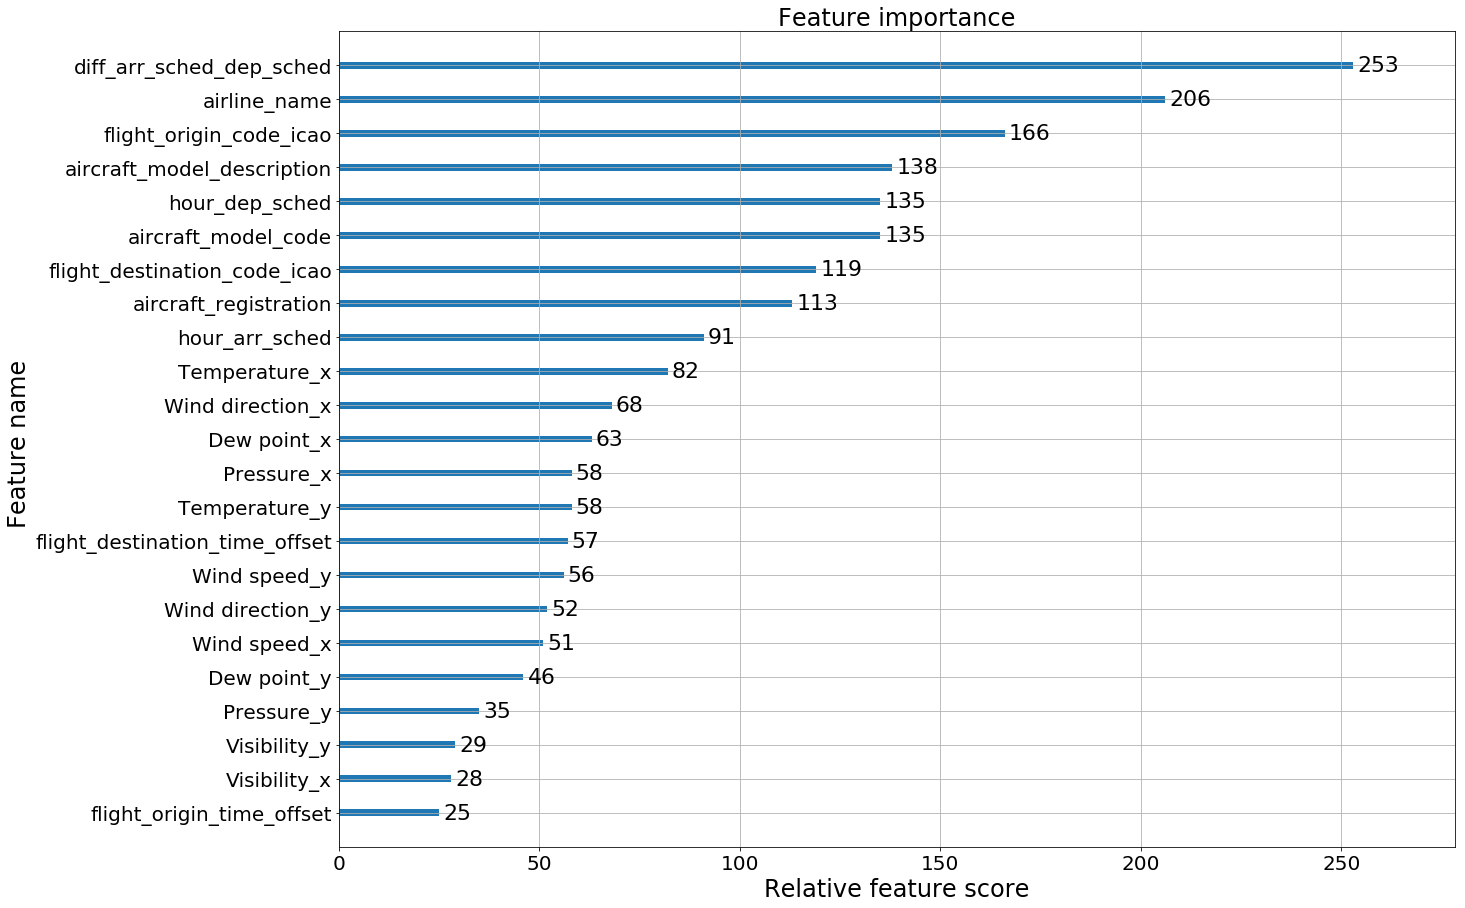

In [109]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
fig, ax = plt.subplots(figsize=(20,15))
plot_importance(xgb_model1,ax=ax, show_values=True)

plt.xlabel("Relative feature score",fontsize=24)
plt.ylabel('Feature name ', fontsize=24)
plt.title('Feature importance', fontsize=24)

plt.show()

In [110]:
# xgb_model1.evals_result_



In [111]:
# pip install mlxtend

In [112]:
# from mlxtend.evaluate import confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix

# # cm = confusion_matrix(y_target=y_test_1step, 
# #                       y_predicted= predictions_1step, 
# #                       binary=True)

# # fig, ax = plot_confusion_matrix(conf_mat=cm)
# # plt.rcParams["figure.figsize"] = (4, 4)
# # plt.show()

# Training step 2 (arrival delay **classification**)

In [113]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits = 10, shuffle = True)

xgb_model2 = XGBClassifier(objective='multi:softprob', learning_rate=0.45, num_class=2, n_jobs=-2)
xgb_val_pred = np.empty([len(y_train_2step),])

for tr_ind, val_ind in kf.split(X_train_2step, y_train_2step):
    X_tr, X_val, y_tr, y_val = X_train_2step.iloc[tr_ind], X_train_2step.iloc[val_ind], y_train_2step.iloc[tr_ind], y_train_2step.iloc[val_ind]
    xgb_model2.fit(X_tr, y_tr, 
              eval_set = [(X_tr, y_tr), (X_val, y_val)], 
              verbose = False, 
              early_stopping_rounds = 10)
    xgb_val_pred[val_ind] = xgb_model2.predict(X_val)

print('Validation accuracy:', accuracy_score(y_train_2step, xgb_val_pred) )

Validation accuracy: 0.8807432232917971


In [114]:
xgb_model2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.45, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-2,
              nthread=None, num_class=2, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [115]:
# print('Validation accuracy:', accuracy_score(y_train_2step, xgb_val_pred) )
Y_train_predict_2step = xgb_model2.predict(X_train_2step)
print('Training accuracy:', accuracy_score(y_train_2step, Y_train_predict_2step) )
predictions_2step = xgb_model2.predict(X_test_2step)

Training accuracy: 0.8815109549400578


In [116]:
print('Test accuracy:', accuracy_score(y_test_2step, predictions_2step) )

Test accuracy: 0.8792038933681993


In [117]:
print(class_report(y_test_2step, predictions_2step, y_score=xgb_model2.predict_proba(X_test_2step), average='micro'))

             precision    recall  f1-score  support     pred   ROC-AUC
0             0.490624  0.861284  0.625141   4830.0   8479.0  0.942481
1             0.979587  0.881577  0.928001  36471.0  32822.0  0.942481
avg / total   0.922404  0.879204  0.892583  41301.0  41301.0  0.942481


In [118]:
perf_report = pd.DataFrame(class_report(y_test_2step, predictions_2step, y_score=xgb_model2.predict_proba(X_test_2step), average='micro'))
display(perf_report)

,precision,recall,f1-score,support,pred,ROC-AUC
0,0.490624,0.861284,0.625141,4830.0,8479.0,0.942481
1,0.979587,0.881577,0.928001,36471.0,32822.0,0.942481
avg / total,0.922404,0.879204,0.892583,41301.0,41301.0,0.942481


# Naive prediction model Arrival

In [119]:
y_test_2step.value_counts()/len(y_test_2step)

1    0.883054
0    0.116946
Name: target_2step, dtype: float64

In [120]:
y_test_2step.value_counts()

1    36471
0     4830
Name: target_2step, dtype: int64

In [121]:
# print(xgb_model2.feature_importances_)

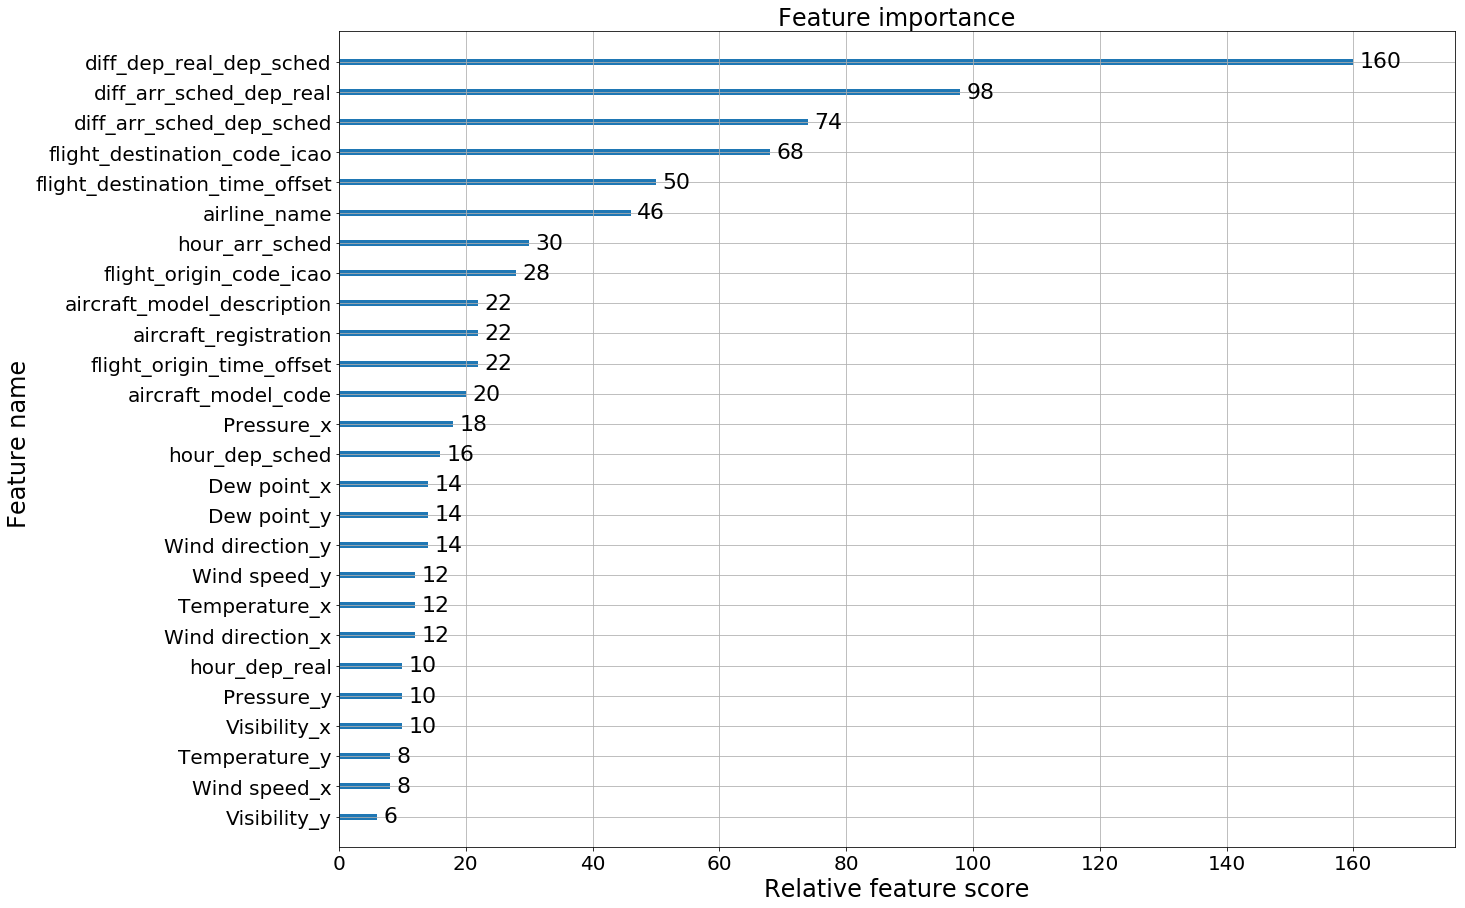

In [122]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
fig, ax = plt.subplots(figsize=(20,15))
plot_importance(xgb_model2,ax=ax, show_values=True)

plt.xlabel("Relative feature score",fontsize=24)
plt.ylabel('Feature name ', fontsize=24)
plt.title('Feature importance', fontsize=24)

plt.show()

C:\tools\miniconda3\envs\agifors\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


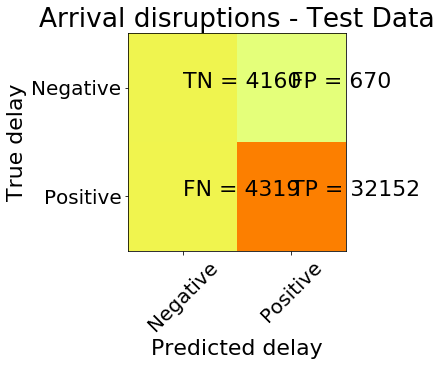

In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_2step,predictions_2step)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Arrival disruptions - Test Data')
plt.ylabel('True delay')
plt.xlabel('Predicted delay')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



## Naive Models and comparison for both steps

In [158]:
import random
def naive_labels_departure():
    x=random.uniform(0,1)

    w1 = 0.629870
    w2 = 0.323347
    if x<=w1:y=0 # Departure delay
    elif x>w1 and x<=w1+w2:
        y=1 # No Delay
    else:
        y=2 # Cancellation
    return y

def naive_labels_arrival():
    x=random.uniform(0,1)
    w1 = 0.888613197
    if x<=w1:
        y=0
    else:
        y=1
    return y

def naive_predictions(len_df,mode_idx):
 
    if mode_idx == "arr":    
        return pd.DataFrame([naive_labels_arrival() for x in range(len_df) ])
    elif mode_idx == "dep":
        return pd.DataFrame([naive_labels_departure() for x in range(len_df) ])
  


# pre-extra eval info

In [125]:
target_1step.value_counts()/len(target_1step)

1    0.629866
2    0.323354
0    0.046780
Name: target_1step, dtype: float64

In [126]:
target_2step.value_counts()/len(target_2step)

1    0.888532
0    0.111468
Name: target_2step, dtype: float64

In [127]:
len(y_test_1step)

43328

In [128]:
y_train_2step.value_counts()/len(y_train_2step)

1    0.5
0    0.5
Name: target_2step, dtype: float64

In [129]:
y_test_2step.value_counts()/len(y_test_2step)

1    0.883054
0    0.116946
Name: target_2step, dtype: float64

In [130]:
len(y_test_2step)

41301

## Extra evaluation steps (naive model 1)

## departures case

In [131]:
# y_test_1step.unique().s
y_train_1step.value_counts()/len(y_train_1step)

2    0.333333
1    0.333333
0    0.333333
Name: target_1step, dtype: float64

# XGBoost model Departures (performance)

In [159]:
naive_m1_train11 = naive_predictions(len(y_train_1step),"dep")
naive_m1_test11 = naive_predictions(len(y_test_1step),"dep")

In [170]:
perf_report = pd.DataFrame(class_report(y_test_1step, predictions_1step, y_score=xgb_model1.predict_proba(X_test_1step), average='micro'))
display(perf_report)

,precision,recall,f1-score,support,pred,ROC-AUC
0,0.530394,0.830784,0.647443,2027.0,3175.0,0.952285
1,0.804972,0.602690,0.689297,27291.0,20433.0,0.741091
2,0.495892,0.698001,0.579840,14010.0,19720.0,0.740858
avg / total,0.692187,0.644179,0.651946,43328.0,43328.0,0.847119


# Naive model Departures (performance)

In [171]:
df_ =np.array(pd.get_dummies(naive_m1_test11,columns = [0]).values.tolist())

In [172]:
perf_report = pd.DataFrame(class_report(y_test_1step, np.array(list(naive_m1_test11[0])), y_score=df_, average='micro'))
display(perf_report)

,precision,recall,f1-score,support,pred,ROC-AUC
0,0.046606,0.625555,0.086748,2027.0,27207.0,0.498754
1,0.630661,0.326042,0.429855,27291.0,14109.0,0.500553
2,0.326541,0.046895,0.082012,14010.0,2012.0,0.500339
avg / total,0.505001,0.249792,0.301330,43328.0,43328.0,0.437344


In [ ]:
predictions_1step

In [ ]:
accu_train11 = accuracy_score(naive_m1_train11,y_train_1step)
accu_test11 = accuracy_score(naive_m1_test11,y_test_1step)
print("accuracy for departure in training set is: ",accu_train11)
print("accuracy for departure in test set is: ",accu_test11)

## arrivals case

# XGBoost model Arrivals (performance)

In [185]:
naive_m1_train12 = naive_predictions(len(y_train_2step),"arr")
naive_m1_test12 = naive_predictions(len(y_test_2step),"arr")

In [186]:
perf_report = pd.DataFrame(class_report(y_test_2step, predictions_2step, y_score=xgb_model2.predict_proba(X_test_2step), average='micro'))
display(perf_report)

,precision,recall,f1-score,support,pred,ROC-AUC
0,0.490624,0.861284,0.625141,4830.0,8479.0,0.942481
1,0.979587,0.881577,0.928001,36471.0,32822.0,0.942481
avg / total,0.922404,0.879204,0.892583,41301.0,41301.0,0.942481


# Naive model Arrivals (performance)

In [187]:
df_ =np.array(pd.get_dummies(naive_m1_test12,columns = [0]).values.tolist())

In [188]:
perf_report = pd.DataFrame(class_report(y_test_2step, np.array(list(naive_m1_test12[0])), y_score=df_, average='micro'))
display(perf_report)

,precision,recall,f1-score,support,pred,ROC-AUC
0,0.117500,0.894410,0.207712,4830.0,36766.0,0.502386
1,0.887541,0.110362,0.196313,36471.0,4535.0,0.502386
avg / total,0.797488,0.202053,0.197646,41301.0,41301.0,0.502386


In [ ]:
accu_train12 = accuracy_score(naive_m2_train12,y_train_2step)
accu_test12 = accuracy_score(naive_m2_test12,y_test_2step)
print("accuracy for arrival in training set is: ",accu_train12)
print("accuracy for arrival in test set is: ",accu_test12)

## Extra evaluation steps (naive model 2)

In [ ]:
def naive_predictions1(len_df):
    return pd.DataFrame([0 for x in range(len_df) ])

## departures case

In [ ]:
# naive_m1_train

In [ ]:
naive_m2_train21 = naive_predictions1(len(y_train_1step))
naive_m2_test21 = naive_predictions1(len(y_test_1step))


In [ ]:
accu_train21 = accuracy_score(naive_m2_train21,y_train_1step)
accu_test21 = accuracy_score(naive_m2_test21,y_test_1step)
print("accuracy for departure in training set is: ",accu_train21)
print("accuracy for departure in test set is: ",accu_test21)

## arrivals case

In [ ]:
naive_m2_train22 = naive_predictions1(len(y_train_2step))
naive_m2_test22 = naive_predictions1(len(y_test_2step))


In [137]:
naive_m1_train12 = naive_predictions(len(y_train_2step),"dep")
naive_m1_test12 = naive_predictions(len(y_test_2step),"dep")

In [ ]:
accu_train22 = accuracy_score(naive_m2_train22,y_train_2step)
accu_test22 = accuracy_score(naive_m2_test22,y_test_2step)
print("accuracy for departure in training set is: ",accu_train22)
print("accuracy for departure in test set is: ",accu_test22)

# Tests

In [ ]:

no_cancelations_df = flight_data[flight_data['flight_departure_real'] != -1 ]
delay_time = no_cancelations_df['flight_departure_real'] - no_cancelations_df['flight_departure_scheduled']
sched_duration = no_cancelations_df['flight_arrival_scheduled'] - no_cancelations_df['flight_departure_scheduled']

In [ ]:
len(y_test_1step)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sched_duration, delay_time, 'ro')
plt.show()

In [ ]:
# y_test_1step.unique().s
y_train_1step.value_counts()/len(y_train_1step)


In [ ]:
np.corrcoef(sched_duration,delay_time)

In [ ]:
print(len(delay_time), len(delay_time[delay_time.between(-1431,4209)]))

In [ ]:
delay_time[delay_time.between(-1431,4209)].hist(bins=100, figsize=(10,10))

In [ ]:
delay_time.plot.box(figsize=(10,10))

In [ ]:
delay_time.describe()

In [ ]:
import seaborn as sns
sns.boxplot(x=delay_time)

In [ ]:
step1=[62049,31687,4602]
step1[:] = [x / sum(step1) for x in step1]

In [ ]:
target_1step.value_counts()

0 Departure delay 77562
1 No delay No cancelation 39609
2 Cancelation 5752

1    62049
2    31687
0     4602